In [2]:
%load_ext autoreload
%autoreload 2

# Week 2: Getting Started with Re-ranker Fine-tuning

When improving RAG systems, starting with a managed re-ranker service can provide quick wins with minimal engineering overhead. This notebook demonstrates how to fine-tune a Cohere re-ranker for better retrieval performance using just a few hundred examples.

## Why Start with Managed Re-rankers?

Re-rankers offer several compelling advantages when you're just getting started:

1. **Data Efficiency**
   - Work effectively with limited data (as few as 256 examples)
   - Only need to learn ranking within small candidate sets
   - Can achieve significant gains without massive training sets

2. **Easy Integration**
   - Drop-in addition to existing retrieval pipelines
   - Progressive improvement without system overhauls
   - No need to re-embed your entire document collection

3. **Quick Implementation**
   - Hosted services handle infrastructure complexity
   - No hyperparameter tuning required
   - Focus on experimentation rather than deployment

## The Power of Hard Negatives

A key aspect of effective re-ranker training is the selection of hard negatives - examples that are similar to the correct answer but shouldn't be ranked highly. For instance:

Query:
```
Name: Ayden
Category: Financial Software
Department: Finance
Location: Berlin, DE
Amount: 1273.45
```

Positive Example:
```
Subscription & Revenue Infrastructure
```

Hard Negatives:
```
Office Equipment Maintenance
Office Supplies & Stationery
Human Resources
```

Hard negatives help your model by:
1. Improving discriminative ability between similar categories
2. Building robustness against noisy results
3. Making efficient use of limited training data

## What We'll Cover

In this notebook, you'll learn how to:
1. Prepare training data with hard negatives
2. Fine-tune a Cohere re-ranker
3. Evaluate performance improvements
4. Compare against baseline approaches

## Prerequisites
- Complete the `1. Synthetic-Transactions.ipynb` notebook first
- Generate at least 256 examples for the fine-tuning process
- Have a Cohere API key ready

Let's dive in and start improving your retrieval performance with re-ranker fine-tuning!

In [5]:
from braintrust import init_dataset

dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)

In [3]:
from pydantic import BaseModel


# Define Pydantic model to store our finetuning data
class FinetuneItem(BaseModel):
    query: str
    relevant_passages: list[str]
    hard_negatives: list[str]


# Get all the labels in our dataset
labels = set([transaction["expected"][0] for transaction in train_data])

In [8]:
import random

finetuning_data = [
    FinetuneItem(
        query=transaction["input"],
        relevant_passages=[transaction["expected"][0]],
        hard_negatives=random.sample(
            [label for label in labels if label != transaction["expected"][0]], k=4
        ),
    )
    for transaction in train_data
    # Generate 2 samples with 4 hard negatives each for each transaction
    for _ in range(2)
]

with open("./data/cohere_finetune.jsonl", "w") as f:
    for item in finetuning_data:
        f.write(item.model_dump_json() + "\n")

## Uploading Our Dataset

A reminder that the fine-tuning itself will take around 1 hour to a day so you'll need to come back to this notebook later down the line when this is done.

Once the dataset has a status `validated`, we can kick off our fine-tuning job.

In [9]:
import cohere

co = cohere.ClientV2()

reranked_dataset = co.datasets.create(
    name="Synthetic Transactions Finetune",
    data=open("./data/cohere_finetune.jsonl", "rb"),
    type="reranker-finetune-input",
)

co.wait(reranked_dataset).dataset.validation_status


...
...
...


'validated'

## Finetuning Our model

Now that we've uploaded our dataset, we can kick off our fine-tuning job. Make sure to indicate that you're doing a re-ranker finetune when creating the job.

In [25]:
from cohere.finetuning import BaseModel, FinetunedModel, Settings

finetune_request = co.finetuning.create_finetuned_model(
    request=FinetunedModel(
        name="finetuned-cohere-reranker",
        settings=Settings(
            base_model=BaseModel(base_type="BASE_TYPE_RERANK"),
            dataset_id=reranked_dataset.id,
        ),
    )
)

In [29]:
response = co.finetuning.get_finetuned_model(finetune_request.finetuned_model.id)
response.finetuned_model.status

'STATUS_READY'

# Benchmarking our Model

We want to quantify the improvement that fine-tuning a model gets us. In order to do so, we'll be using the same retrieval evals as before to benchmark our fine-tuned model. Since we're building a model here that will suggest relevant categories for a given transaction, we'll be measuring the following two metrics.    

- Recall : Whether the correct category is in the top N results
- MRR : The mean reciprocal rank of the correct category in the top N results

We want to mainly measure two things

- How much of an improvement does a fine-tuned model get us over a pure embedding based approach
- How does the fine-tuned model perform against the default Cohere re-ranker

In order to do so, we'll be benchmarking our fine-tuned model against the default text-embedding-3-small model as well as the default Cohere re-ranker. We'll use `braintrust` here to run our evaluations and compare the results between our different configurations since it's where we've stored our evaluation data and provides an easy way to share our results with others.



In [4]:
import lancedb

db = lancedb.connect("./lancedb")
table = db.open_table("categories")

In [6]:
from braintrust import Eval, Score
from lancedb.rerankers import CohereReranker
from helpers import get_metrics_at_k, task


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]

rerankers = [
    # Remember to replace this with your fine-tuned model id
    CohereReranker(model_name="0486d248-8476-40f6-a5bf-1ef6fd8a65dd-ft"),
    CohereReranker(model_name="rerank-english-v3.0"),
    None,
]

results = []

for reranker in rerankers:
    results.append(
        await Eval(
            "fine-tuning",  # Replace with your project name
            data=eval_data, # We're using the eval data here to do the benchmarking
            task=lambda query: task(user_query=query, table=table, reranker=reranker, max_k=25),  # Replace with your LLM call
            scores=[evaluate_braintrust],
        )
    )

Experiment fine-tuning-1731570018 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570018
fine-tuning (data): 66it [00:00, 68690.83it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731570018 compared to synthetic-transactions-eval-d206957a:
72.73% (+31.82%) 'mrr@1'    score	(24 improvements, 3 regressions)
81.31% (+31.57%) 'mrr@3'    score	(32 improvements, 3 regressions)
81.62% (+29.14%) 'mrr@5'    score	(33 improvements, 3 regressions)
72.73% (+31.82%) 'recall@1' score	(24 improvements, 3 regressions)
90.91% (+28.79%) 'recall@3' score	(19 improvements, 0 regressions)
92.42% (+18.18%) 'recall@5' score	(12 improvements, 0 regressions)

3.92s (+222.03%) 'duration'	(0 improvements, 66 regressions)

See results for fine-tuning-1731570018 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570018


Experiment fine-tuning-1731570030 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570030
fine-tuning (data): 66it [00:00, 19508.39it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731570030 compared to fine-tuning-1731570018:
22.73% (-50.00%) 'mrr@1'    score	(2 improvements, 35 regressions)
25.76% (-55.56%) 'mrr@3'    score	(3 improvements, 43 regressions)
27.20% (-54.42%) 'mrr@5'    score	(3 improvements, 44 regressions)
22.73% (-50.00%) 'recall@1' score	(2 improvements, 35 regressions)
30.30% (-60.61%) 'recall@3' score	(0 improvements, 40 regressions)
36.36% (-56.06%) 'recall@5' score	(0 improvements, 37 regressions)

3.30s (-61.13%) 'duration'	(66 improvements, 0 regressions)

See results for fine-tuning-1731570030 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570030


Experiment fine-tuning-1731570041 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570041
fine-tuning (data): 66it [00:00, 42289.04it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731570041 compared to fine-tuning-1731570030:
40.91% (+18.18%) 'mrr@1'    score	(19 improvements, 7 regressions)
49.75% (+23.99%) 'mrr@3'    score	(28 improvements, 8 regressions)
52.47% (+25.28%) 'mrr@5'    score	(33 improvements, 8 regressions)
40.91% (+18.18%) 'recall@1' score	(19 improvements, 7 regressions)
62.12% (+31.82%) 'recall@3' score	(25 improvements, 4 regressions)
74.24% (+37.88%) 'recall@5' score	(26 improvements, 1 regressions)

2.05s (-125.85%) 'duration'	(64 improvements, 2 regressions)

See results for fine-tuning-1731570041 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731570041


# Results Analysis and Next Steps

Now that we've run our evaluations, let's take a closer look at the results. We want to compare the performance of our fine-tuned model against the default Cohere re-ranker as well as the default vector search baseline without a re-ranker.

In [7]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Fine-Tuned Reranker", "Default Reranker", "No Reranker"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Fine-Tuned Reranker,0.73,0.81,0.82,0.73,0.91,0.92
Default Reranker,0.23,0.26,0.27,0.23,0.30,0.36
No Reranker,0.41,0.50,0.52,0.41,0.62,0.74


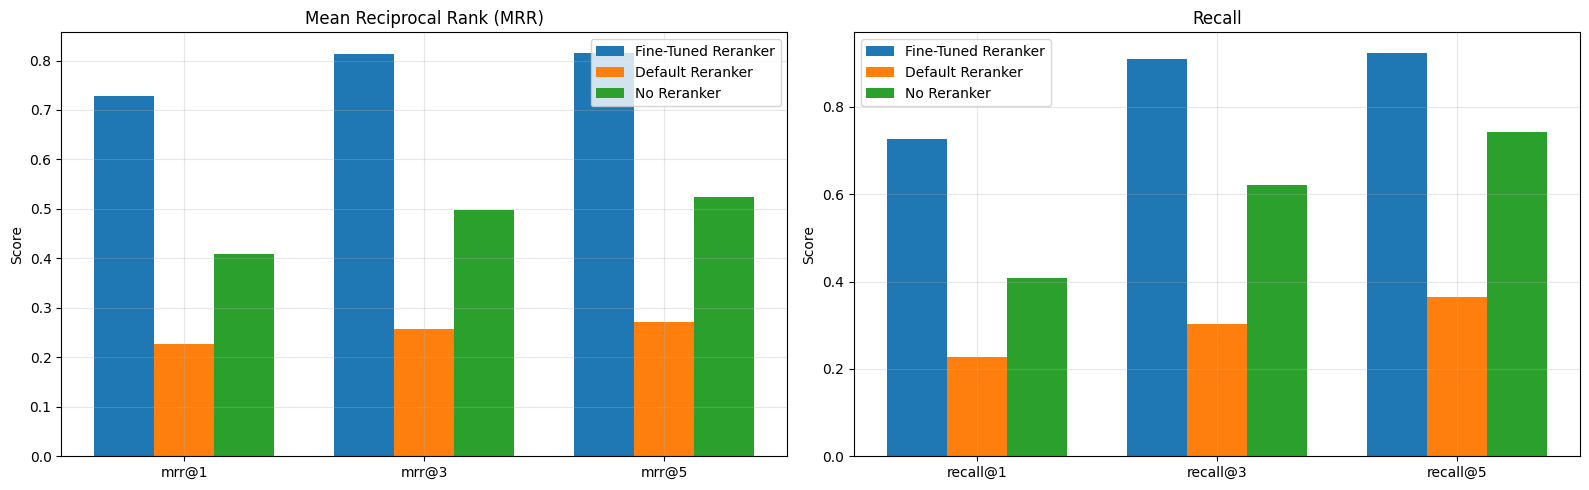

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot MRR scores
mrr_cols = ['mrr@1', 'mrr@3', 'mrr@5']
x = np.arange(len(mrr_cols))
width = 0.25

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax1.bar(x + offset, df.loc[model, mrr_cols], width, label=model)

ax1.set_title('Mean Reciprocal Rank (MRR)')
ax1.set_xticks(x)
ax1.set_xticklabels(mrr_cols)
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Recall scores
recall_cols = ['recall@1', 'recall@3', 'recall@5']
x = np.arange(len(recall_cols))

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax2.bar(x + offset, df.loc[model, recall_cols], width, label=model)

ax2.set_title('Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(recall_cols)
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




With just 256 examples, our fine-tuned reranker showed a 60%+ average increase in recall and a 49% average increase in mean reciprocal rank (MRR) compared to the text-embedding-3-small model. On the contrary, using the default Cohere re-ranker actually degraded performance at the cost of increased latency.

Ultimately when you have a limited amount of data, fine-tuning a reranker is a no-brainer. It allows you to outperform the default model and get a good return on your investment. When looking to fine-tune it on your own data, some key considerations to look at are

1. **Model Selection** : We chose to finetune on the cohere re-rankers but they have english and multi-lingual options to choose from. There are also other managed providers such as Jina that offer re-ranker models. It's important to experiment and find one that works for you
2. **Dataset Quality** : In our example here, we mined for hard negatives by simply randomly selecting other categories. You might want to adopt a more sophisticated approach such as looking at cosine similarity or getting a language model involved.

In the next notebook, we'll look at how we might fine-tune an open source model using the Sentence Transformers library. We'll need to manage our hyper-parameters, loss functions and training loop but at the same time, be able to squeeze out significantly more performance out of our model. 